In [294]:
import pandas as pd
from impyute.imputation.cs import mice#
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer#
import missingno as msno#
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial.distance import squareform, pdist
from missingpy import KNNImputer
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set()
pd.set_option("display.max_rows", 8)
plt.rcParams['figure.figsize'] = (9, 6)
from missingpy import MissForest
import io
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn import decomposition
from mpl_toolkits.mplot3d import axes3d, Axes3D
from sklearn.decomposition import PCA, KernelPCA
from sklearn.datasets import make_circles
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [220]:
Dapp = pd.read_csv("horse-colic.data" , sep = "\s+", names = ["V"+str(i) for i in range(28)])
Dtest = pd.read_csv("horse-colic.test" , sep = "\s+", names = ["V"+str(i) for i in range(28)])
liste_drop = ["V22","V23","V24","V25","V26","V27"]
Dapp = Dapp.drop(liste_drop , axis = 1)
Dtest = Dtest.drop(liste_drop , axis = 1)
Dapp = Dapp.replace("?",np.nan)
Dtest = Dtest.replace("?",np.nan)

#Dtest
#Dapp
#On utilisera une méthode d'imputation qui gère différentes types pour les variables ! (cf Référence)
#On se doit tout de même spécifier le type des variables


In [276]:
d = {}
liste_categorical = [] ; liste_numerical = []
for i in range(22):
    if(i in list(range(3)) + list(range(6 , 15)) + [16 , 17 , 20]):
        d["V"+str(i)] = "category"
        liste_categorical.append("V"+str(i))
    else:
        d["V"+str(i)] = "float64"
        liste_numerical.append("V"+str(i))
liste_categorical
liste_numerical

['V3', 'V4', 'V5', 'V15', 'V18', 'V19', 'V21']

In [222]:
Dapp = Dapp.astype(d)
Dtest = Dtest.astype(d)
Dapp_num = Dapp.select_dtypes(include=['float64']) ; Dapp_cat = Dapp.select_dtypes(include=['category'])
Dtest_num = Dtest.select_dtypes(include=['float64']) ; Dtest_cat = Dtest.select_dtypes(include=['category'])
Dtest_cat.loc[: , "V9"] = pd.Series(pd.Categorical(Dtest_cat.loc[: , "V9"], categories=["1","2","3"]))

C:\Users\Benco\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [223]:
def g(l):
    return np.array([float(x) for x in l])

imputed_training=mice(np.array(list(map(g , Dapp_num.values))))
imputed_test = mice(np.array(list(map(g , Dtest_num.values))))

Dapp_num_imputed = pd.DataFrame(list(map(np.ravel, (list(imputed_training))))).round(2)
Dapp_num_imputed.columns = liste_numerical

Dtest_num_imputed = pd.DataFrame(list(map(np.ravel, (list(imputed_test))))).round(2)
Dtest_num_imputed.columns = liste_numerical

In [224]:
## On a généré quelques valeurs négatives, il est nécessaire d'effectuer de nouvelles imputations sur nos données
Dapp_num_imputed[Dapp_num_imputed < 0] = np.nan
Dtest_num_imputed[Dtest_num_imputed < 0] = np.nan

distances_app = pdist(Dapp_num_imputed.values, metric='euclidean')
dist_matrix_app = squareform(distances_app)
matrice_distance_app = pd.DataFrame(list(map(np.ravel, (list(dist_matrix_app))))).round(2)

distances_test = pdist(Dtest_num_imputed.values, metric='euclidean')
dist_matrix_test = squareform(distances_test)
matrice_distance_test = pd.DataFrame(list(map(np.ravel, (list(dist_matrix_test))))).round(2)


In [225]:
#on ne peut pas se permettre de prendre des poids uniformes
#en effet, il se peut que le 2e plus proche soit en réalité très loin du point par rapport au premier

imputer = KNNImputer(n_neighbors=15, weights="distance")
Dapp_num_imputed = pd.DataFrame(list(map(np.ravel, (list(imputer.fit_transform(Dapp_num_imputed)))))).round(2)

imputer = KNNImputer(n_neighbors=3, weights="distance")
Dtest_num_imputed = pd.DataFrame(list(map(np.ravel, (list(imputer.fit_transform(Dtest_num_imputed)))))).round(2)

Dapp_num_imputed.columns = liste_numerical ; Dtest_num_imputed.columns = liste_numerical
#le choix du nombre de voisins est difficile, on fait donc des choix arbitraires


C:\Users\Benco\Anaconda3\lib\site-packages\sklearn\utils\validation.py:432: DeprecationWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  DeprecationWarning)
C:\Users\Benco\Anaconda3\lib\site-packages\sklearn\utils\validation.py:432: DeprecationWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  DeprecationWarning)
C:\Users\Benco\Anaconda3\lib\site-packages\missingpy\utils.py:124: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
C:\Users\Benco\Anaconda3\lib\site-packages\sklearn\utils\validation.py:432: DeprecationWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  DeprecationWarning)
C:\Users\Benco\Anaconda3\lib\site-packages\sklearn\utils\validation.py:432: Deprecati

In [8]:
{lab : 1-(len(Dtest_num[lab].dropna())/len(Dtest_num)) for lab in liste_numerical} 
{lab : 1-(len(Dapp_num[lab].dropna())/len(Dapp_num)) for lab in liste_numerical} 


{'V3': 0.19999999999999996,
 'V4': 0.07999999999999996,
 'V5': 0.19333333333333336,
 'V15': 0.8233333333333334,
 'V18': 0.09666666666666668,
 'V19': 0.10999999999999999,
 'V21': 0.6599999999999999}

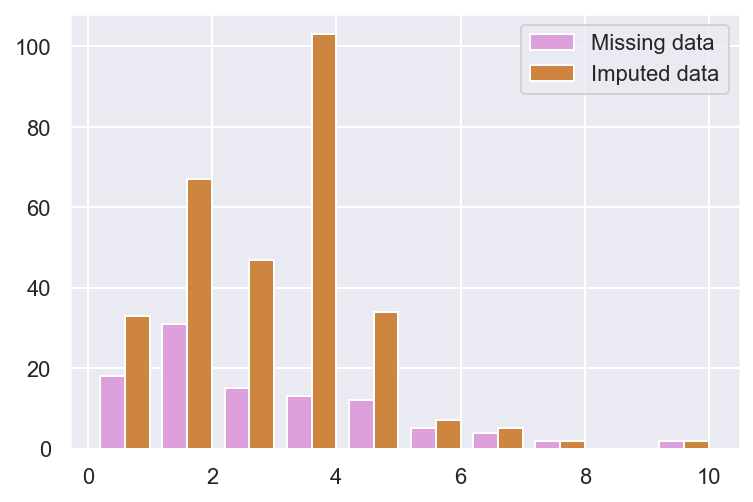

In [54]:
x = Dapp_num.V21
y = Dapp_num_imputed.V21
#L'objectif est de comparer les distributions pour voir si l'on observe une certaine cohérence après imputation
#on compare les distributions avant/après
#on calcule aussi la proportion de données manquantes pour être sûr que la comparaison ait un sens.
#il faut que le % de données manquantes ne soit ni trop faible ni trop élevé pour pouvoir comparer
#on peut faire une "évaluation" visuelle de notre imputation sur cette variable choisie
plt.hist([x, y], label=['Missing data', 'Imputed data'] , color = ["plum","peru"])
plt.legend(loc='upper right')
plt.show()

In [ ]:
##La variable ID hôpital sera supprimée, qui peut être considéré (globalement) comme un identifiant pour les chevaux
##en effet, si l'on conserve cette variable en termes d'ajustement, on sera performant.
##cependant, nos algorithmes de prédiction ne seront pas bons d'un point de vue de la généralisation
#62 lignes des données de test sont des nouveaux identifiants -- > overfitting

#Réf : Unleash Machine Learning Techniques, De Raghav Bali, Dipanjan Sarkar, Brett Lantz p.393
#Advances in Computing and Information Technolog, Natarajan Meghanathan, Dhinaharan Nagamalai, Nabendu Chaki P.352

In [293]:
Dapp_cat = Dapp_cat.drop(["V2"] , axis = 1) ; Dtest_cat = Dtest_cat.drop(["V2"] , axis = 1)
cat_cols = [Dapp_cat.columns.get_loc(col) for col in Dapp_cat.select_dtypes(['category']).columns.tolist()]

imputer = MissForest(random_state = 100)
Dapp_cat_imputed = imputer.fit_transform(Dapp_cat , cat_vars = cat_cols)
Dapp_cat_imputed = pd.DataFrame(list(map(np.ravel, (list(Dapp_cat_imputed)))))
Dapp_cat_imputed.columns = [x for x in liste_categorical if(x!="V2")] #if(x!="V2")
Dapp_cat_imputed = Dapp_cat_imputed.apply(lambda x : x.astype(int).astype(str).astype("category") , axis = 1)

imputer = MissForest(random_state = 100)
Dtest_cat_imputed = imputer.fit_transform(Dtest_cat , cat_vars = cat_cols)
Dtest_cat_imputed = pd.DataFrame(list(map(np.ravel, (list(Dtest_cat_imputed)))))
Dtest_cat_imputed.columns = [x for x in liste_categorical if(x!="V2")] #if(x!="V2")
Dtest_cat_imputed = Dtest_cat_imputed.apply(lambda x : x.astype(int).astype(str).astype("category") , axis = 1)
Dtest_cat_imputed.loc[: , "V9"] = pd.Series(pd.Categorical(Dtest_cat_imputed.loc[: , "V9"], categories=["1","2","3"]))
#une modalité de V9 n'est pas présente dans la variable V9 des données de test : il faut rajouter une catégorie
#pour la variable V9 des données de test

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


In [175]:
Dapp_cat_imputed.shape

(300, 14)

In [11]:
{lab : 1-(len(Dtest_cat[lab].dropna())/len(Dtest)) for lab in liste_categorical if(lab != "V2")} 
{lab : 1-(len(Dapp_cat[lab].dropna())/len(Dapp)) for lab in liste_categorical if(lab != "V2")}
#les proportions de données manquantes pour chaque varible

{'V0': 0.0033333333333332993,
 'V1': 0.0,
 'V6': 0.18666666666666665,
 'V7': 0.22999999999999998,
 'V8': 0.15666666666666662,
 'V9': 0.10666666666666669,
 'V10': 0.18333333333333335,
 'V11': 0.1466666666666666,
 'V12': 0.18666666666666665,
 'V13': 0.3466666666666667,
 'V14': 0.3533333333333334,
 'V16': 0.33999999999999997,
 'V17': 0.3933333333333333,
 'V20': 0.55}

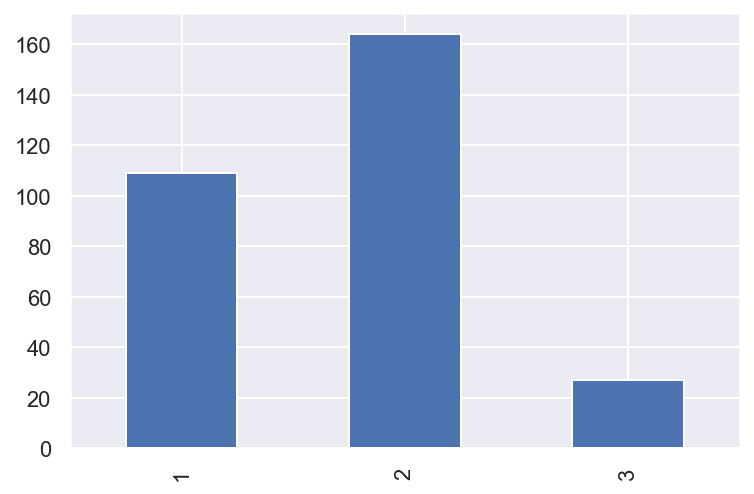

In [37]:
Dapp_cat_imputed.V13.value_counts().sort_index().plot(kind = "bar")
#en pratique, il est nécessaire de vérifier la distribution des variables avant\après imputation
#on trace donc des barplot pour avoir une idée

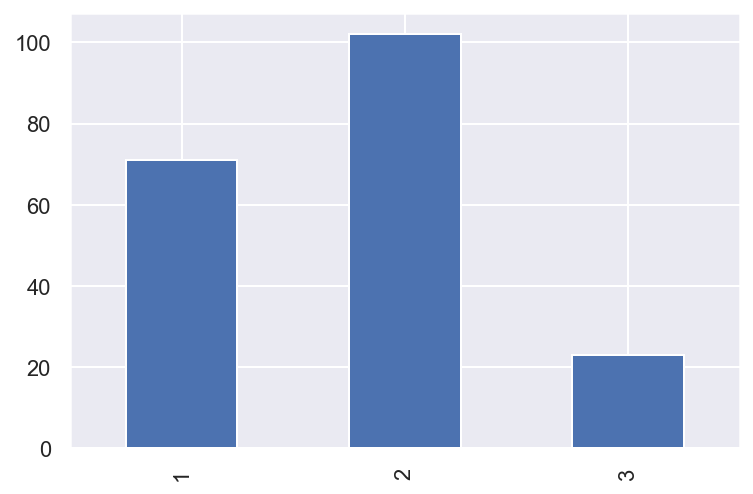

In [13]:
Dapp_cat["V13"].value_counts().sort_index().plot(kind = "bar")

In [294]:
Dapp_imputed = pd.concat([Dapp_num_imputed.reset_index(drop=True), Dapp_cat_imputed], axis=1)
Dapp_imputed.columns = [int(x[1:]) for x in Dapp_imputed.columns]
Dapp_imputed = Dapp_imputed.sort_index(axis = 1)
Dapp_imputed.columns = ["V"+str(x) for x in Dapp_imputed.columns]

Dtest_imputed = pd.concat([Dtest_num_imputed.reset_index(drop=True), Dtest_cat_imputed], axis=1)
Dtest_imputed.columns = [int(x[1:]) for x in Dtest_imputed.columns]
Dtest_imputed = Dtest_imputed.sort_index(axis = 1)
Dtest_imputed.columns = ["V"+str(x) for x in Dtest_imputed.columns]
Dtest_imputed

,V0,V1,V3,V4,V5,V6,V7,V8,V9,V10,...,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21
0,2,1,38.5,54.0,20.0,3,1,2,2,3,...,1,2,2,5.90,4,2,42.0,6.3,3,3.08
1,2,1,37.6,48.0,36.0,1,1,1,1,3,...,2,2,1,4.81,3,5,44.0,6.3,1,5.00
2,1,1,37.7,44.0,28.0,3,4,3,2,5,...,4,1,1,4.27,3,5,45.0,70.0,3,2.00
3,1,1,37.0,56.0,24.0,3,1,4,2,4,...,3,1,1,3.78,4,5,35.0,61.0,3,2.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,2,1,37.8,42.0,40.0,1,1,1,1,1,...,1,2,1,6.16,3,3,36.0,6.2,1,2.86
65,1,1,38.0,60.0,12.0,1,1,2,1,2,...,1,1,1,4.12,1,4,44.0,65.0,3,2.00
66,2,1,38.0,42.0,12.0,3,1,3,1,1,...,1,2,1,5.55,4,1,37.0,5.8,2,2.74
67,2,1,37.6,88.0,36.0,3,1,1,1,3,...,2,1,3,1.50,4,4,44.0,6.0,2,10.47


In [271]:
Dapp_imputed

,V0,V3,V4,V5,V15,V18,V19,V21,V1_1,V1_9,...,V16_3,V16_4,V17_1,V17_2,V17_3,V17_4,V17_5,V20_1,V20_2,V20_3
0,0,0.499670,-0.213775,-0.158252,0.567525,-0.130276,-0.618779,0.298297,1,0,...,1,0,0,0,0,0,1,0,0,1
1,1,1.564306,0.581707,-0.654050,-1.759118,0.372268,2.335979,-0.726139,1,0,...,0,1,0,1,0,0,0,0,1,0
2,0,0.195488,-1.153889,-0.406151,0.721534,-1.336382,-0.684354,0.123925,1,0,...,0,0,1,0,0,0,0,0,1,0
3,1,1.412215,3.329733,3.312330,0.259506,0.171250,-0.665067,1.671478,0,1,...,1,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,0,-1.477513,0.003175,-0.406151,-0.263026,-0.230785,-0.031685,0.218377,1,0,...,0,1,0,0,0,1,0,0,0,1
297,1,-1.021240,0.003175,-0.034303,0.584026,1.377356,-0.680497,0.443608,1,0,...,1,0,0,0,0,0,1,0,0,1
298,1,-2.542150,1.015606,-0.406151,-0.560044,0.372268,-0.711356,0.291032,1,0,...,0,1,0,0,0,1,0,0,0,1
299,1,-1.477513,-1.153889,-0.654050,-1.544605,-1.034856,1.448780,-1.452689,1,0,...,0,1,1,0,0,0,0,1,0,0


In [295]:
Dtest_imputed.to_pickle("Dtest_imputed.pkl")
Dapp_imputed.to_pickle("Dapp_imputed.pkl")

In [278]:
Dapp_imputed = pd.read_pickle("Dapp_imputed.pkl")
Dtest_imputed = pd.read_pickle("Dtest_imputed.pkl")

#test = PolynomialFeatures(2, interaction_only=True, include_bias=False).fit_transform(Dtest_imputed.select_dtypes(include=['float64']))
#test = pd.DataFrame(list(map(np.ravel, (list(test)))))
#test.columns = ["W"+str(x) for x in test.columns]
#Dtest_imputed = pd.concat([Dtest_imputed.reset_index(drop=True), test], axis=1)

#app = PolynomialFeatures(2, interaction_only=True, include_bias=False).fit_transform(Dapp_imputed.select_dtypes(include=['float64']))
#app = pd.DataFrame(list(map(np.ravel, (list(app)))))
#app.columns = ["W"+str(x) for x in app.columns]
#Dapp_imputed = pd.concat([Dapp_imputed.reset_index(drop=True), app], axis=1)


#liste_numerical = liste_numerical + list(test.columns)

In [244]:
liste_numerical

['V3',
 'V4',
 'V5',
 'V15',
 'V18',
 'V19',
 'V21',
 'W0',
 'W1',
 'W2',
 'W3',
 'W4',
 'W5',
 'W6',
 'W7',
 'W8',
 'W9',
 'W10',
 'W11',
 'W12',
 'W13',
 'W14',
 'W15',
 'W16',
 'W17',
 'W18',
 'W19',
 'W20',
 'W21',
 'W22',
 'W23',
 'W24',
 'W25',
 'W26',
 'W27']

In [180]:
liste_cat_bis = [x for x in liste_categorical if(x not in ["V0" , "V2"] )]

In [270]:
liste_cat_bis

['V1',
 'V2',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V16',
 'V17',
 'V20']

In [279]:
##Régression logistique
scaler = StandardScaler()
Dapp_imputed[liste_numerical] = scaler.fit_transform(Dapp_imputed[liste_numerical])
Dapp_imputed["V0"] = pd.Series([1 if(x=="1") else 0 for x in Dapp_imputed["V0"]])
Dapp_imputed = Dapp_imputed.astype({"V0" : "int32"})
Dapp_imputed = pd.get_dummies(Dapp_imputed , columns = liste_cat_bis , drop_first = True)

Dtest_imputed[liste_numerical] = scaler.transform(Dtest_imputed[liste_numerical])
Dtest_imputed["V0"] = pd.Series([1 if(x=="1") else 0 for x in Dtest_imputed["V0"]])
Dtest_imputed = Dtest_imputed.astype({"V0" : "int32"})
Dtest_imputed = pd.get_dummies(Dtest_imputed , columns = liste_cat_bis , drop_first = True)

Dapp_imputed
Dtest_imputed

,V0,V3,V4,V5,V15,V18,V19,V21,V1_9,V6_2,...,V14_3,V16_2,V16_3,V16_4,V17_2,V17_3,V17_4,V17_5,V20_2,V20_3
0,0,0.499360,-0.649931,-0.652144,0.691955,-0.430871,-0.697777,0.066706,0,0,...,0,0,0,1,1,0,0,0,0,1
1,0,-0.869582,-0.866179,0.338749,0.121173,-0.229722,-0.697777,1.414402,0,0,...,0,0,1,0,0,0,0,1,0,0
2,1,-0.717478,-1.010345,-0.156697,-0.161599,-0.129148,1.760979,-0.691373,0,0,...,0,0,1,0,0,0,0,1,0,1
3,1,-1.782210,-0.577848,-0.404421,-0.418189,-1.134892,1.413588,-0.691373,0,0,...,0,0,0,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,0,-0.565373,-1.082428,0.586472,0.828104,-1.034317,-0.701637,-0.087717,0,0,...,0,0,1,0,0,1,0,0,0,0
65,1,-0.261164,-0.433683,-1.147590,-0.240147,-0.229722,1.567984,-0.691373,0,0,...,0,0,0,0,0,0,1,0,0,1
66,0,-0.261164,-1.082428,-1.147590,0.508676,-0.933743,-0.717077,-0.171948,0,0,...,0,0,0,1,0,0,0,0,1,0
67,0,-0.869582,0.575477,0.338749,-1.612117,-0.229722,-0.709357,5.253932,0,0,...,1,0,0,1,0,0,1,0,1,0


In [280]:
X_train = Dapp_imputed.drop(["V0"] , axis = 1) ; Y_train = Dapp_imputed["V0"]
X_test = Dtest_imputed.drop(["V0"] , axis = 1) ; Y_test = Dtest_imputed["V0"]

In [264]:
logreg = LogisticRegression(penalty = "l2", C = 2 , solver = "lbfgs" , max_iter = 500 , tol = 1e-6)
logreg.fit(X_train, Y_train)
y_pred = logreg.predict(X_test)
y_fit = logreg.predict(X_train)
accuracy_score(y_pred, Y_test)
#accuracy_score(y_fit, Y_train)



0.6764705882352942

In [265]:
#Faisons une ACP pour avoir une intuition sur la séparabilité linéaire des données
pca = decomposition.PCA(n_components=3)
pca.fit(X_train)
X = pca.transform(X_train)

Text(0, 0.5, 'Second Principal Component')

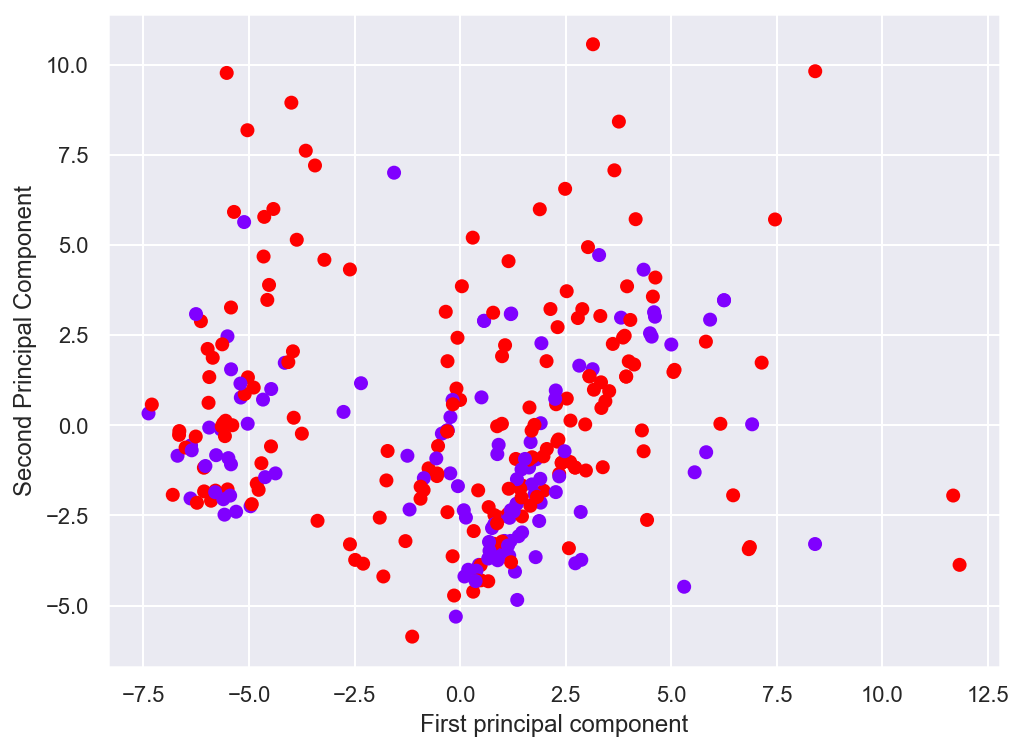

In [266]:
plt.figure(figsize=(8,6))
plt.scatter(X[:,0] , X[:,1] ,c=Y_train,cmap='rainbow')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')

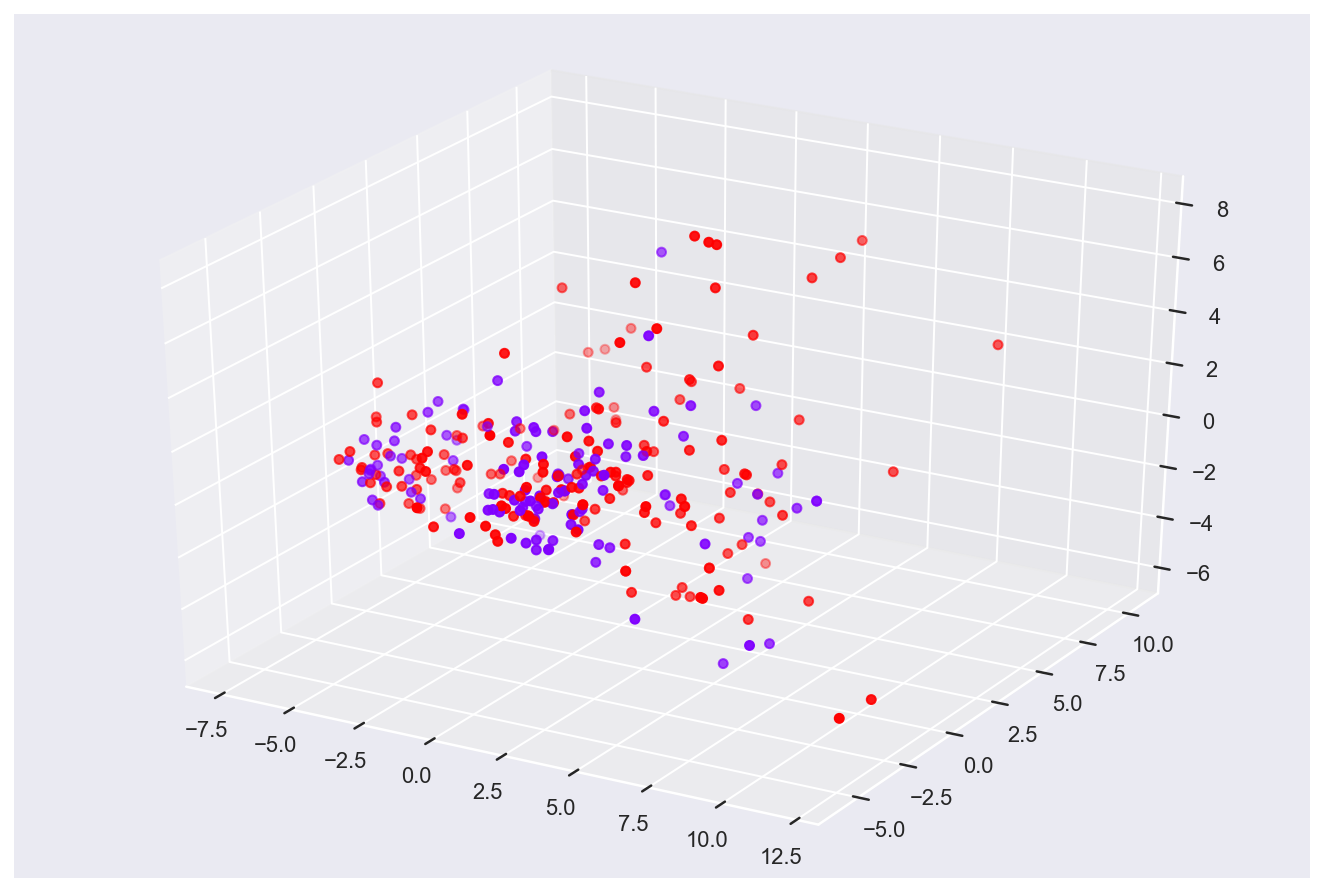

In [267]:
fig = plt.figure()

ax = Axes3D(fig)
ax.scatter3D(X[:,0], X[:,1], X[:,2], c=Y_train , cmap = "rainbow")
## ce ne sont que des outils de visualisation et au vue de notre score sur les Dapp, on pourrait penser que les donnéees
#ne sont pas linéairement séparables (on utilise un classifieur linéaire) -- > information très importante
## il y a de fortes chances que l'algorithme itératif de la régression logistique n'ait atteint qu'un minimum
#local

In [268]:
def svc_param_selection_lin(X, y,Cs):
    Cs = list(np.unique([round(x,3) for x in Cs]))
    parameters = {'kernel':['linear'], 'C':Cs}
    svc = svm.SVC(gamma = "auto")
    clf = GridSearchCV(svc, parameters , return_train_score = True , cv = 5)
    clf.fit(X_train, Y_train)
    return clf.best_params_

C = svc_param_selection_lin(X_train, Y_train , np.linspace(5,8,100))["C"]
#Naturellement, on se dirigera vers les SVM non linéaires de manière à déterminer un hyperplan dans un espace 
#de plus grande dimension

clf = LinearSVC(C = C , max_iter = 10000)
clf.fit(X_train , Y_train)
y_pred = clf.predict(X_test)
y_fit = clf.predict(X_train)
accuracy_score(y_pred, Y_test)
#accuracy_score(y_fit, Y_train)
#on constate donc que les performances sont similaires, on aura beau augmenté la constante de tolérance cela
#ne fera pas augmenter le taux de bon classés dans les données d'apprentissage au contraire ...
#on insiste bien sur l'erreur d'ajustement car c'est un moyen de juger la non-séparabilité 
#avec les données de départ, il semble difficile de déterminer un hyperplan comme en régression logistique
#on décide donc d'opter pour les SVM à noyaux

C:\Users\Benco\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Benco\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.6470588235294118

In [269]:
def svc_param_selection(X, y,Cs):
    Cs = list(np.unique([round(x,3) for x in Cs]))
    parameters = {'kernel':['rbf'], 'C':Cs}
    svc = svm.SVC(gamma = "auto")
    clf = GridSearchCV(svc, parameters , return_train_score = True , cv = 5)
    clf.fit(X_train, Y_train)
    return clf.best_params_
C = svc_param_selection(X_train, Y_train , np.linspace(5,10,500))["C"]
C
ksvm = svm.SVC(kernel="rbf", gamma = "auto" , C = C)               
ksvm.fit(X_train, Y_train)
y_pred = ksvm.predict(X_test)
y_fit = ksvm.predict(X_train)
accuracy_score(y_pred, Y_test)
#accuracy_score(y_fit, Y_train)
#le choix de gamma peut s'avérer très compliqué, il en est de même pour le choix du noyau ainsi que de la tolérance,
#on se limite donc à chercher une constante de tolérance optimal pour un noyau RBF
#on pourrait vérifier que si C est grand alors le taux de classification est égal à 1
#on voit aussi que les performances sur les données de test sont légèrement moins bonnes

C:\Users\Benco\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.6470588235294118

In [159]:
def svc_param_selection_poly(X, y,Cs , degree):
    Cs = list(np.unique([round(x,3) for x in Cs]))
    parameters = {'kernel':['poly'], 'C':Cs , "degree" : degree}
    svc = svm.SVC(gamma = "auto")
    clf = GridSearchCV(svc, parameters , return_train_score = True , cv = 5)
    clf.fit(X_train, Y_train)
    return clf.best_params_
params_poly = svc_param_selection_poly(X_train, Y_train , np.linspace(5,8,100) , list(range(0,9)))
ksvm_poly = svm.SVC(kernel="poly", degree = params_poly["degree"] , C = params_poly["C"])               
ksvm_poly.fit(X_train, Y_train)
y_pred = ksvm_poly.predict(X_test)
y_fit = ksvm_poly.predict(X_train)
accuracy_score(y_pred, Y_test)
#accuracy_score(y_fit, Y_train)
## sur la base de nos grilles choisies, le meilleur score obtenu provient d'une SVM linéaire classique
## on décide de ne pas optimiser la constante du polynôme

C:\Users\Benco\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Benco\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.7352941176470589

In [46]:
#grille à changer

0.8166666666666667

In [144]:
#choix de m avec l'erreur OOB
clf = RandomForestClassifier(random_state = 0,
                             n_estimators = 100 , max_features = 6 , min_samples_split = 2,
                            oob_score = True)
clf.fit(X_train, Y_train)
y_pred = clf.predict(X_test)
y_fit = clf.predict(X_train)
accuracy_score(y_pred, Y_test)
#accuracy_score(y_fit, Y_train)


0.6911764705882353

In [126]:
1 > best
    
clf.o

NameError: name 'best' is not defined

In [147]:
def oob_m(liste): #renvoie le m minimisant l'erreur OOB
    l = []
    for m in liste:
        clf = RandomForestClassifier(random_state = 0,
                             n_estimators = 100 , max_features = m , min_samples_split = 2,
                            oob_score = True)
        clf.fit(X_train, Y_train)
        l.append((m , clf.oob_score_))
    return sorted(l , key = lambda x : x[1] , reverse = False)[0][0]

In [270]:
clf = RandomForestClassifier(random_state = 0,
                             n_estimators = 100 , max_features = oob_m(range(1,8)) , min_samples_split = 2,
                            oob_score = True)
clf.fit(X_train, Y_train)
y_pred = clf.predict(X_test)
y_fit = clf.predict(X_train)
accuracy_score(y_pred, Y_test)

#dans notre cas de figure, déterminer m à l'aide de l'erreur OOB peut être une source de sur-apprentissage
#on optera pour une validation croisée pour déterminer m

0.75

In [271]:
def rfc_CV(ms):
    rfc = RandomForestClassifier(random_state = 0, min_samples_split = 2,
                            oob_score = True , n_estimators = 100)
    param_grid = {'max_features': ms}
    CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
    CV_rfc.fit(X_train, Y_train)
    return CV_rfc.best_params_["max_features"]


In [272]:
ms = ['auto', 'sqrt', 'log2' , 1 , 2 , 3 , 4 , 5 , 6]
m = rfc_CV(ms)

C:\Users\Benco\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [273]:
rfc = RandomForestClassifier(random_state = 0,
                             n_estimators = 100 , max_features = rfc_CV(ms) , min_samples_split = 2,
                            oob_score = True)
rfc.fit(X_train, Y_train)
y_pred = rfc.predict(X_test)
y_fit = rfc.predict(X_train)
accuracy_score(y_pred, Y_test)
#le meilleur modèle jusqu'à présent


C:\Users\Benco\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.75

In [274]:
def knn_CV(ks):
    neigh = KNeighborsClassifier()
    param_grid = {'n_neighbors': ks}
    CV_knn = GridSearchCV(estimator=neigh, param_grid=param_grid, cv= 3)
    CV_knn.fit(X_train, Y_train)
    return CV_rfc.best_params_["max_features"]
k = knn_CV(list(range(1,20)))

C:\Users\Benco\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [275]:
neigh = KNeighborsClassifier(n_neighbors=k)
neigh.fit(X_train, Y_train)
y_pred = neigh.predict(X_test)
y_fit = neigh.predict(X_train)
accuracy_score(y_pred, Y_test)


neigh = KNeighborsClassifier(n_neighbors=2)
neigh.fit(X_train, Y_train)
y_pred = neigh.predict(X_test)
y_fit = neigh.predict(X_train)
accuracy_score(y_pred, Y_test)
#en utilisant k=2, on obtient un score qui n'est pas si faible --> nous ne sommes pas dans un problème de grande dimension
#à partir du moment ou l'on a enlevé la variable correspondant au numéro d'hôpital


0.6764705882352942

In [292]:
def ada_CV(ns):
    ada = AdaBoostClassifier(random_state=0)
    param_grid = {'n_estimators': ns}
    CV_ada = GridSearchCV(estimator=ada, param_grid=param_grid, cv= 3)
    CV_ada.fit(X_train, Y_train)
    return CV_ada.best_params_["n_estimators"]
B = ada_CV(list(range(1,30)))

C:\Users\Benco\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [293]:
clf = AdaBoostClassifier(n_estimators = B, random_state=0)
clf.fit(X_train, Y_train)
y_pred = clf.predict(X_test)
y_fit = clf.predict(X_train)
accuracy_score(y_pred, Y_test)

0.7058823529411765

In [297]:
clf = GradientBoostingClassifier(n_estimators=2, learning_rate=1.0,max_depth=1, random_state=0).fit(X_train, Y_train)
y_pred = clf.predict(X_test)
y_fit = clf.predict(X_train)
accuracy_score(y_pred, Y_test)

0.7205882352941176